# Bitcoin Prediction (copied)

In [1]:
%matplotlib inline

In [3]:
import gc
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [6]:
import plotly.offline as py
import plotly.graph_objs as go

In [46]:
btc_data = pd.read_csv('bitcoin.csv')
btc_data.head()  # no missing value

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-05-16,8504.41,8508.43,8175.49,8368.83,6.760220e+09,144878000000
1,2018-05-15,8705.19,8836.19,8456.45,8510.38,6.705710e+09,148283000000
2,2018-05-14,8713.10,8881.12,8367.97,8716.79,7.364150e+09,148403000000
3,2018-05-13,8515.49,8773.55,8395.12,8723.94,5.866380e+09,145022000000
4,2018-05-12,8441.44,8664.86,8223.50,8504.89,6.821380e+09,143743000000


In [48]:
def add_volatility(data, coins=['BTC', 'ETH']):
  """
  data: input data, pandas DataFrame
  coins: default is for 'btc and 'eth'. It could be changed as needed
  This function calculates the volatility and close_off_high of each given coin in 24 hours, 
  and adds the result as new columns to the DataFrame.
  Return: DataFrame with added columns
  """
  for coin in coins:
    # calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
             coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
  return data

def create_model_data(data):
  """
  data: pandas DataFrame
  This function drops unnecessary columns and reverses the order of DataFrame based on decending dates.
  Return: pandas DataFrame
  """
  #data = data[['Date']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume','close_off_high','volatility']]]
  data = data[['Date']+[metric for metric in ['Close','Volume']]]
  data = data.sort_values(by='Date')
  return data

def split_data(data, training_size=0.8):
  """
  data: Pandas Dataframe
  training_size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, window_len=10):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coins: coin datas which will be used as the input. Default is 'btc', 'eth'
  window_len: is an integer to be used as the look back window for creating a single input sample.
  This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
  Return: X, the input for our model as a python list which later needs to be converted to numpy array.
  """
  norm_cols = ['Close', 'Volume']
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs

def create_outputs(data, window_len=10):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coin: the target coin in which we need to create the output labels for
  window_len: is an integer to be used as the look back window for creating a single input sample.
  This function will create the labels array for our training and validation and normalize it between 0 and 1
  Return: Normalized numpy array for 'Close' prices of the given coin
  """
  return (data['Close'][window_len:].values / data['Close'][:-window_len].values) - 1
# both input and output is relatively to the price of the first day

def to_array(data):
  """
  data: DataFrame
  This function will convert list of inputs to a numpy array
  Return: numpy array
  """
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)

In [15]:
def date_labels():
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]

def plot_results(history, model, Y_target, coin):
  plt.figure(figsize=(25, 20))
  plt.subplot(311)
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title(coin + ' Model Loss')
  plt.legend(['Training', 'Test'])

  plt.subplot(312)
  plt.plot(Y_target)
  plt.plot(model.predict(X_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Training Set')
  plt.legend(['Actual','Predicted'])

  ax1 = plt.subplot(313)
  plt.plot(test_set[coin + '_Close'][window_len:].values.tolist())
  plt.plot(((np.transpose(model.predict(X_test)) + 1) * test_set[coin + '_Close'].values[:-window_len])[0])
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Test Set')
  plt.legend(['Actual','Predicted'])
  date_list = date_labels()
  ax1.set_xticks([x for x in range(len(date_list))])
  for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
    label.set_visible(False)

  plt.show()

In [16]:
def show_plot(data):
  fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)', fontsize=12)
  ax2.set_ylabel('Volume ($ bn)', fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])  # set ticks at corresponding place
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime), data['Close'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data['Volume'].values)
  fig.tight_layout()
  plt.show()

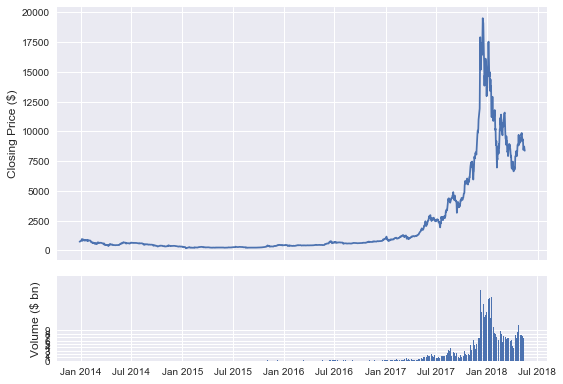

In [30]:
show_plot(btc_data)

In [49]:
btc_data = create_model_data(btc_data)

In [50]:
btc_data.head()

,Date,Close,Volume
1600,2013-12-28,727.83,32505800.0
1599,2013-12-29,745.05,19011300.0
1598,2013-12-30,756.13,20707700.0
1597,2013-12-31,754.01,20897300.0
1596,2014-01-01,771.40,22489400.0


In [62]:
btc_data.drop('Date', axis=1, inplace=True)

In [63]:
train_set, test_set = split_data(btc_data)

In [64]:
train_set.head()

,Close,Volume
1600,727.83,32505800.0
1599,745.05,19011300.0
1598,756.13,20707700.0
1597,754.01,20897300.0
1596,771.40,22489400.0


In [65]:
print train_set.shape
print test_set.shape

(1280, 2)
(321, 2)


In [66]:
X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set)
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set)

In [67]:
X_train, X_test = to_array(X_train), to_array(X_test)

In [68]:
print X_train.shape
print X_test.shape

(1270, 10, 2)
(311, 10, 2)


In [69]:
neurons = 512                 
activation_function = 'tanh'  
loss = 'mse'                  
optimizer="adam"              
dropout = 0.25                 
batch_size = 12               
epochs = 53                                
training_size = 0.8

In [38]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 0.25
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

In [70]:
# clean up the memory
gc.collect()
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 10, 512)           1054720   
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 512)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 10, 512)           2099200   
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 512)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
__________

In [71]:
# train model on data
btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, 
                            batch_size=batch_size, verbose=0, validation_data=(X_test, Y_test_btc), shuffle=False)

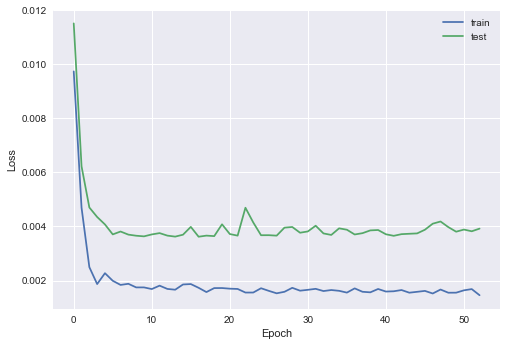

In [73]:
plt.plot(btc_history.epoch, btc_history.history['loss'], label='train')
plt.plot(btc_history.epoch, btc_history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

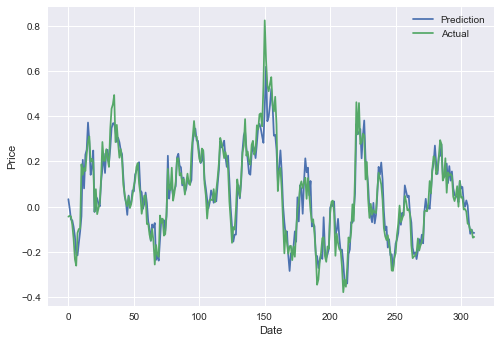

In [74]:
y_pred = btc_model.predict(X_test)
plt.plot(y_pred, label='Prediction')
plt.plot(Y_test_btc, label='Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

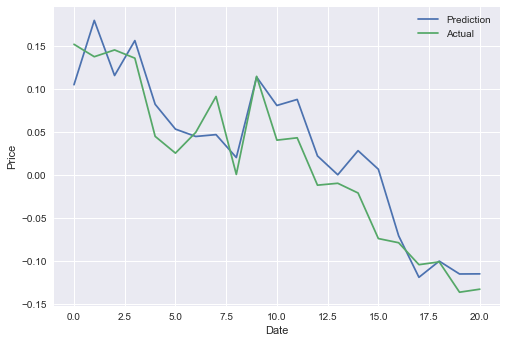

In [75]:
# zoom in
plt.plot(y_pred[290:], label='Prediction')
plt.plot(Y_test_btc[290:], label='Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

### Check accuracy

#### Treat the model as an classification model and check its accuracy

In [99]:
pred_class = [1 if x>0 else 0 for x in y_pred[1:]-y_pred[:-1]]
actual_class = [1 if x>0 else 0 for x in Y_test_btc[1:]-Y_test_btc[:-1]]

In [107]:
def acc(pred, actual):
    correct = 0
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            correct += 1
    print float(correct)/len(pred)

In [109]:
acc(pred_class, actual_class)

0.674193548387
